In [1]:
pip install torch torchvision torchaudio pandas numpy


  Using cached torchvision-0.19.0-1-cp310-cp310-win_amd64.whl (1.3 MB)
  Using cached torchaudio-2.4.0-cp310-cp310-win_amd64.whl (2.4 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install tensorflow


  Using cached tensorflow-2.17.0-cp310-cp310-win_amd64.whl (2.0 kB)
  Using cached tensorflow_intel-2.17.0-cp310-cp310-win_amd64.whl (385.0 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
  Using cached tensorboard-2.17.0-py3-none-any.whl (5.5 MB)
  Using cached wrapt-1.16.0-cp310-cp310-win_amd64.whl (37 kB)
  Using cached h5py-3.11.0-cp310-cp310-win_amd64.whl (3.0 MB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached grpcio-1.65.4-cp310-cp310-win_amd64.whl (4.1 MB)
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached ml_dtypes-0.4.0-cp310-cp310-win_amd64.whl (126 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import PIL
import tensorflow as tf
import pathlib
 
from PIL import ImageShow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Download Dataset

In [16]:
import pandas as pd
import pathlib
from PIL import Image
import os

my_data = pd.read_csv("./bee_imgs/bee_data.csv")
dataset_path = "./bee_imgs"
data_dir = pathlib.Path(dataset_path)

# Check if the varroa directory contains images
varroa = list(data_dir.glob('varroa/*'))
print(f"Found {len(varroa)} images in varroa category.")

if varroa:
    img = Image.open(str(varroa[0]))
    img.show()
else:
    print("No images found in the varroa directory.")


Found 472 images in varroa category.


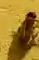

In [17]:
my_data = pd.read_csv("./bee_imgs/bee_data.csv")
dataset_path = "./bee_imgs"
data_dir = pathlib.Path(dataset_path)

varroa = list(data_dir.glob('varroa/*'))
PIL.Image.open(str(varroa[0]))

#Use to print out how many photos are in all the photos in thaae bee_imgs directory
#image_count = len(list(data_dir.glob('*/*.png')))
#print(image_count)

#use to print out how many photos per category in the CSV
#print(my_data['health'].value_counts())

# Create Dataset
Validation split splits the images into 80% for training and 20% for validation

In [18]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
#Prints how many classes are in the new dataset
#print(class_names)

Found 5172 files belonging to 6 classes.
Using 4138 files for training.
Found 5172 files belonging to 6 classes.
Using 1034 files for validation.


# Visualize Dataset
Uncomment to see a sampling of 9 random images that exist in the training data

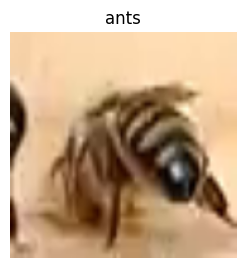

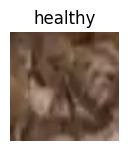

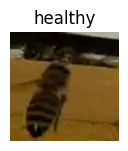

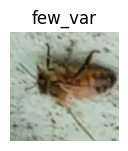

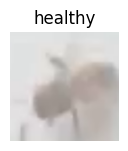

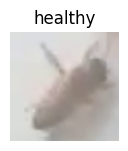

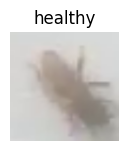

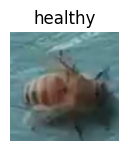

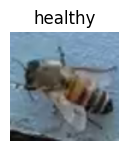

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.show() #NEEDED. Will not display images unless this is added.

# Configure Dataset
dataset.cache(): keeps images in memory after they're loaded off the disk for the first epoch
<br>dataset.prefetch(): overlaps data preprocessing and model execution while training

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Standardize Dataset

In [22]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

# Assuming train_ds is already defined
# Replace 'train_ds' with your actual training dataset variable

# Define the normalization layer
normalization_layer = layers.Rescaling(1./255)

# Apply the normalization to the dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Extract a batch of images and labels
image_batch, labels_batch = next(iter(normalized_ds))

# Inspect the first image in the batch
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))  # Should print values between 0.0 and 1.0

0.35111552 0.9495506


In [23]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# print(np.min(first_image), np.max(first_image))

# Create Model
Consists of three convolutional blocks with each having a max pooling layers
<br>The fully connected layer is activated by the ReLU function

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

num_classes = 6
img_height = 180  # replace with your actual image height
img_width = 180   # replace with your actual image width

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


e:\AI Projects\Verona_Mites\Updated_Code\virtualenv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# num_classes = 6

# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

# Compile Data
Use Adam optimizer and the Sparse Categorical Croessentropy loss function


In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Summary

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [30]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 61s 472ms/step - accuracy: 0.9362 - loss: 0.2012 - val_accuracy: 0.9400 - val_loss: 0.2067
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 51s 394ms/step - accuracy: 0.9845 - loss: 0.0426 - val_accuracy: 0.9371 - val_loss: 0.2556
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 53s 408ms/step - accuracy: 0.9950 - loss: 0.0199 - val_accuracy: 0.9439 - val_loss: 0.2388
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 411ms/step - accuracy: 0.9953 - loss: 0.0167 - val_accuracy: 0.9449 - val_loss: 0.2773
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 412ms/step - accuracy: 0.9965 - loss: 0.0115 - val_accuracy: 0.9429 - val_loss: 0.2643
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 413ms/step - accuracy: 0.9969 - loss: 0.0137 - val_accuracy: 0.9342 - val_loss: 0.2835
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 53s 411ms/step - accuracy: 0.9912 - loss: 0.0242 - val_accuracy: 0.9178 - val_loss: 0.3857
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 412ms/step - accuracy: 0.9967 - loss: 0

# Visualize Training Results

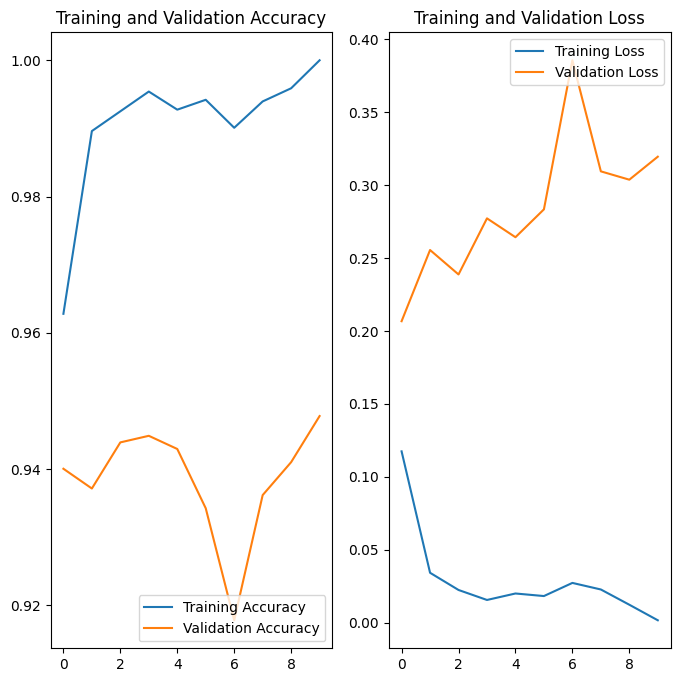

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
# Save the model
model.save('model.h5')


# Predict on New data

Use the commented paths below to check different types of bee png's from the predictions folder. The prediction folder contains different images to how well the data predicts the following:
* Bee drawing
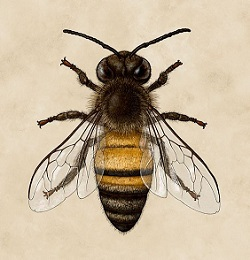
* Yellow and Black stripes
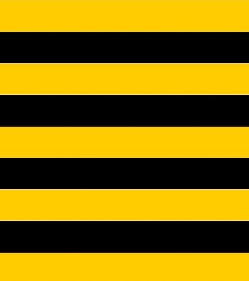
* Healthy Bees
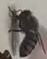
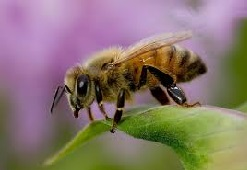
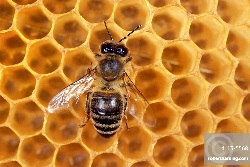
* Bees with pollen (not being robbed)
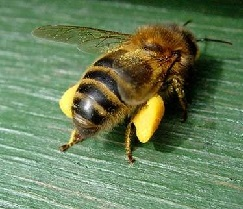
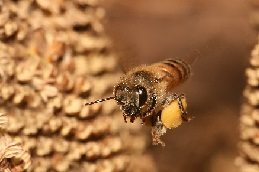
* Bees with deformed wings
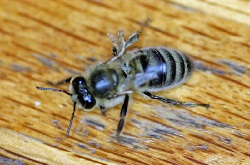
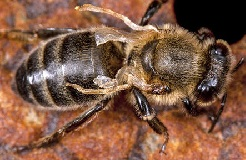
* Bees visibly infected with varroa mites
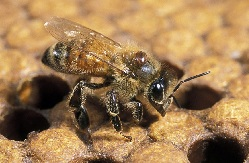
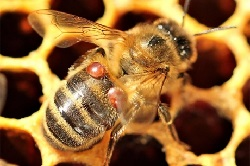
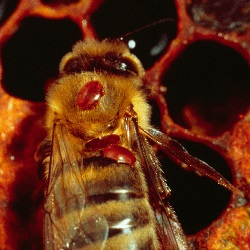


In [33]:
#Bee Drawing
bee_drawing = "../input/new-data-for-predictions/Predictions/bee_drawing.png"

#Yellow and Black Stripes
bee_pattern = "../input/new-data-for-predictions/Predictions/bee_pattern.png"

#Healthy Bees
healthy_bee_from_data  = "../input/bee-images-separated/bee_imgs/healthy/001_054.png"
healthy_bee_side = "../input/new-data-for-predictions/Predictions/healthy_bee_side_profile.png"
healthy_bee_top = "../input/new-data-for-predictions/Predictions/healthy_bee_top_view.png"

#Bees with Pollen
bee_with_pollen_1 = "../input/new-data-for-predictions/Predictions/honey_bee_not_robbed_1.png"
bee_with_pollen_2 = "../input/new-data-for-predictions/Predictions/honey_bee_not_robbed_2.png"

#Bees with Deformed Wings
unhealthy_bee_1 = "../input/new-data-for-predictions/Predictions/unhealthy_bee_1.png"
unhealthy_bee_2 = "../input/new-data-for-predictions/Predictions/unhealthy_bee_2.png"

#Bees Infected with Varroa Mites
varroa_infected_1 = "../input/new-data-for-predictions/Predictions/varroa_infected_1.png"
varroa_infected_2 = "../input/new-data-for-predictions/Predictions/varroa_infected_2.png"
varroa_infected_3 = "../input/new-data-for-predictions/Predictions/varroa_infected_3.png"



In [38]:
#Replace the file path with any from the previous section and run the section below to see the results
bee_img = "bee_imgs/varroa/038_002.png"

In [39]:
#For pictures off the internet
#_url = "https://"
#_path = tf.keras.utils.get_file('File_name', origin=_url)


img = keras.preprocessing.image.load_img(
    bee_img, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to the category {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
This image most likely belongs to the category varroa with a 99.97 percent confidence.


# Predictions Results:
 <br>bee_drawing = **ants** with a **99.83** percent confidence.
 <br><br>bee_pattern = **robbed** with a **100.00** percent confidence.
 <br><br>healthy_bee_from_data = **healthy** with a **99.95** percent confidence.
 <br><br>healthy_bee_side = **ants** with a **90.64** percent confidence.
 <br><br>healthy_bee_top = **healthy** with a **99.84** percent confidence.
 <br><br>bee_with_pollen_1 = **ants** with a **99.08** percent confidence.
 <br><br>bee_with_pollen_2 = **few_var** with a **88.72** percent confidence.
 <br><br>unhealthy_bee_1 = **ants** with a **100.00** percent confidence.
 <br><br>unhealthy_bee_2= **robbed** with a **99.99** percent confidence.
 <br><br>varroa_infected_1 = **healthy** with a **100.00** percent confidence.
 <br><br>varroa_infected_2 = **healthy** with a **100.00** percent confidence.
 <br><br>varroa_infected_3 =**ants** with a **100.00** percent confidence.